In [705]:
import math
import numpy as np
import matplotlib.pyplot as plt
from random import Random
from time import time
from inspyred import ec, benchmarks
from collections import Counter

In [706]:
class WorkoutRoutine(benchmarks.Benchmark):
    def __init__(self, userLevel, equipment, requestMuscles, time, userID, exercises):
        self.userLevel = userLevel.lower()
        self.time = time  # horas
        self.exercises = exercises  # diccionario {id: ejercicio}
        self.length = time * 6  # máx 6 ejercicios por hora
        self.equipment = equipment
        self.requestMuscles = requestMuscles
        self.userID = userID
        self.maximize = True
        self.bounder = ec.DiscreteBounder([1, 3005])

        self.difficulty_map = {
            "beginner": 0,
            "novice": 1,
            "intermediate": 2,
            "advanced": 3,
            "expert": 4,
            "master": 5
        }

        self.difficulty_minutes = {
            "beginner": 10,
            "novice": 12,
            "intermediate": 14,
            "advanced": 16,
            "expert": 18,
            "master": 20
        }

    def generator(self, random, args):
        candidate = [random.choice(range(3005)) for _ in range(self.length)]
        return candidate
    
    def evaluator(self, candidates, args):
        fitness = []
        for candidate in candidates:
            routine = self.get_exercises(candidate)
            n = len(routine)

            y_penalties = self.repetition_penalties(candidate)
            
            y_factor = sum(y_penalties) / n
            
            min_used = self.total_minutes(routine)
            min_total = self.time * 60
            min_factor = min(min_used / min_total, 1)
            
            muscles_factor = self.trained_muscles(routine) # porcentaje de músculos entrenados
            
            difficulty_factor = self.difficulty_score(routine)
            
            equipment_factor = self.used_equipment(routine)
            
            value = 100 * y_factor * min_factor * muscles_factor * difficulty_factor * equipment_factor
            
            # Bonus
            if value < 100:
                bonus = self.calculate_bonus(routine)
                value = min(value + bonus, 100)
            """ print(f"y_penalties: {y_penalties}")
            print(f"y_factor: {y_factor}")
            print(f"min_factor: {min_factor}")
            print(f"muscles_factor: {muscles_factor}")
            print(f"difficulty_factor: {difficulty_factor}")
            print(f"equipment_factor: {equipment_factor}")
            print(f"value: {value}")
            print(f"bonus: {bonus}") """
            fitness.append(value)
        return fitness

    def get_exercises(self, candidate):
        return [self.exercises[i] for i in candidate]

    def total_minutes(self, routine):
        return sum(self.difficulty_minutes.get(ex['DifficultyLevel'].strip().lower(), 10) for ex in routine)

    def repetition_penalties(self, candidate):
        penalties = [1] * len(candidate)
        for i, eid in enumerate(candidate):
            for j in range(i):
                if candidate[j] == eid:
                    dist = i - j
                    if dist <= 2:
                        penalties[i] = 0.95
                    elif dist <= 8:
                        penalties[i] = 0.99
                    else:
                        penalties[i] = 1
                    break
        return penalties

    def difficulty_score(self, routine):
        user_level = self.difficulty_map.get(self.userLevel, 0)
        scores = []
        for ex in routine:
            ex_level = self.difficulty_map.get(ex['DifficultyLevel'].strip().lower(), 0)
            diff = ex_level - user_level
            if diff > 0:
                score = max(0, 1 - 0.05 * diff)
            else:
                score = max(0, 1 - 0.03 * abs(diff))
            scores.append(score)
        return sum(scores) / len(scores)

    def used_equipment(self, routine):
        used = set()
        for ex in routine:
            if ex['PrimaryEquipment']:
                used.add(ex['PrimaryEquipment'])
            if ex['SecondaryEquipment']:
                used.add(ex['SecondaryEquipment'])
        if not self.equipment:
            return 1
        return min(0.1 * (len(used) / len(self.equipment)) + 0.9, 1)
    
    # TODO: check the muscle factor calculation
    def trained_muscles(self, routine):
        target_muscles = [ex['TargetMuscleGroup'].strip().lower()
                        for ex in routine if ex['TargetMuscleGroup']]
        muscle_counts = Counter(target_muscles)
        requested = [m.strip().lower() for m in self.requestMuscles]

        if not requested:
            return 1

        # 1. Cuántos músculos solicitados han sido entrenados al menos una vez
        covered = sum(1 for m in requested if muscle_counts[m] > 0)
        coverage = covered / len(requested)

        # 2. Evaluar el equilibrio del reparto (desviación respecto al ideal)
        total_requested_ej = sum(muscle_counts[m] for m in requested)
        if total_requested_ej == 0:
            return 0  # ninguno entrenado

        ideal = total_requested_ej / len(requested)
        balance = 1 - sum(abs(muscle_counts[m] - ideal) for m in requested) / total_requested_ej

        # 3. Penalización por músculos no solicitados
        extra = [m for m in muscle_counts if m not in requested]
        penalty = len(extra) / len(muscle_counts) if muscle_counts else 1

        # Final
        factor = coverage * balance * (1 - penalty)

        return max(min(factor, 1), 0)



    def calculate_bonus(self, routine):
        extra_bonus = 0
        seen_regions = set()
        for ex in routine:
            muscle = ex['TargetMuscleGroup']
            region = ex['BodyRegion']
            if muscle not in self.requestMuscles:
                if region in seen_regions:
                    extra_bonus += 0.1
                else:
                    extra_bonus += 0.05
                seen_regions.add(region)
        return extra_bonus

In [707]:
# getting the exercises form the CSV file
import pandas as pd

df = pd.read_csv('../assets/exercises.csv')

In [708]:
test = [756,983,367,1255,1234]

# Define the problem

In [709]:
userLevel = "beginner"
equipment = []
requestMuscles = ["Abdominals", "Chest", "Shoulders"]
duration = 1
userID = 12345
exercises = df.to_dict(orient='records')
problem = WorkoutRoutine(userLevel, equipment, requestMuscles, duration, userID, exercises)
problem.evaluator([test], None)

[0.4]

In [710]:

# Print the routine according to the best solution
for i in test:
    print(exercises[i]['TargetMuscleGroup'] + " - " + exercises[i]['DifficultyLevel'] + " - " + exercises[i]['BodyRegion'])

Quadriceps - Intermediate - Full Body
Quadriceps - Beginner - Lower Body
Quadriceps - Beginner - Lower Body
Quadriceps - Intermediate - Lower Body
Quadriceps - Intermediate - Lower Body


# Executing the GA

In [711]:
# Initializing the observer
def diversity(population):
    return np.array([i.candidate for i in population]).std(axis=0).mean()

def fitness_diversity_observer(population, num_generations, num_evaluations, args):
    """Observer to track best fitness and diversity."""
    best = max(population).fitness
    div = diversity(population)

    args['best_fitness_historic'].append(best)
    args['diversity_historic'].append(div)

In [ ]:
seed = time() # the current timestamp
prng = Random()
prng.seed(seed)

ga = ec.GA(prng)
ga.selector = ec.selectors.fitness_proportionate_selection
ga.variator = [ec.variators.n_point_crossover,
               ec.variators.bit_flip_mutation]
ga.replacer = ec.replacers.generational_replacement
ga.terminator = ec.terminators.generation_termination

best_fitness_historic = []
diversity_historic = []
ga.observer = [fitness_diversity_observer, ec.observers.stats_observer]

final_pop = ga.evolve(generator=problem.generator,
                      evaluator=problem.evaluator,
                      bounder=problem.bounder,
                      maximize=problem.maximize,
                      pop_size=100,
                      max_generations=100,
                      num_elites=10,
                      num_selected=100,
                      crossover_rate=1,
                      num_crossover_points=1,
                      mutation_rate=0.05,
                      best_fitness_historic=best_fitness_historic,
                      diversity_historic=diversity_historic)

best = max(ga.population)
print('Best Solution: {0}: {1}'.format(str(best.candidate), best.fitness))


Generation Evaluation      Worst       Best     Median    Average    Std Dev
---------- ---------- ---------- ---------- ---------- ---------- ----------
         0        400 0.15000000       69.0 5.35462962 7.64965933 11.0128991

Generation Evaluation      Worst       Best     Median    Average    Std Dev
---------- ---------- ---------- ---------- ---------- ---------- ----------
         1        500        0.2       71.5 10.7416666 19.5191447 19.3962245

Generation Evaluation      Worst       Best     Median    Average    Std Dev
---------- ---------- ---------- ---------- ---------- ---------- ----------
         2        600        0.2      72.75 26.4902777 31.4378294 23.0374969

Generation Evaluation      Worst       Best     Median    Average    Std Dev
---------- ---------- ---------- ---------- ---------- ---------- ----------
         3        700        0.4      72.75 44.3166666 34.7882716 21.5572639

Generation Evaluation      Worst       Best     Median    Average    Std

In [713]:
# Print the routine according to the best solution, ordered by TargetMuscleGroup
sorted_routine = sorted(best.candidate, key=lambda x: exercises[x]['TargetMuscleGroup'])
for i in sorted_routine:
    print(exercises[i]['TargetMuscleGroup'] + " - " + exercises[i]['DifficultyLevel'] + " - " + exercises[i]['BodyRegion'])

Abdominals - Beginner - Midsection
Abdominals - Intermediate - Full Body
Chest - Beginner - Upper Body
Chest - Beginner - Upper Body
Shoulders - Beginner - Upper Body
Shoulders - Advanced - Full Body


C:\Users\pablo\AppData\Local\Temp\ipykernel_17660\1678658813.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


Text(0, 0.5, 'Diversity')

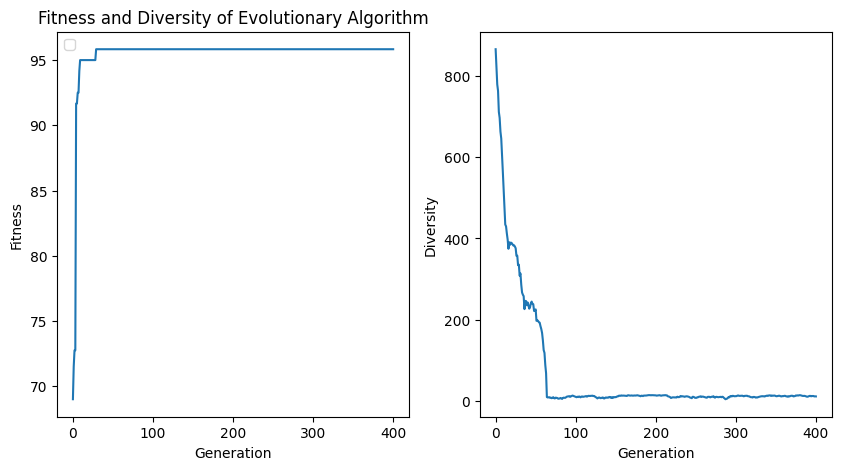

In [714]:
# plot the fitness and diversity in two separate subplots
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.plot(best_fitness_historic)
plt.xlabel('Generation')
plt.ylabel('Fitness')
plt.title('Fitness and Diversity of Evolutionary Algorithm')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(diversity_historic)
plt.xlabel('Generation')
plt.ylabel('Diversity')